In [1]:
import torch, os
torch.manual_seed(0) 
import warnings;warnings.filterwarnings("ignore")
from HINT.dataloader import csv_three_feature_2_dataloader, generate_admet_dataloader_lst
from HINT.molecule_encode import MPNN, ADMET 
from HINT.icdcode_encode import GRAM, build_icdcode2ancestor_dict
from HINT.protocol_encode import Protocol_Embedding
from HINT.model import HINTModel 
device = torch.device("cuda:0")  # cuda:0
if not os.path.exists("figure"):
	os.makedirs("figure")

In [2]:
# choose the phase to be explored
base_name  = 'phase_I' # 'phase_I', 'phase_II', 'phase_III'
datafolder = "data"
train_file = os.path.join(datafolder, base_name + '_train.csv')
valid_file = os.path.join(datafolder, base_name + '_valid.csv')
test_file  = os.path.join(datafolder, base_name + '_test.csv')

In [3]:
mpnn_model = MPNN(mpnn_hidden_size = 50, mpnn_depth=3, device = device)
admet_model_path = "save_model/admet_model.ckpt"
if not os.path.exists(admet_model_path):
	admet_dataloader_lst = generate_admet_dataloader_lst(batch_size=32)
	admet_trainloader_lst = [i[0] for i in admet_dataloader_lst]
	admet_testloader_lst = [i[1] for i in admet_dataloader_lst]
	admet_model = ADMET(molecule_encoder = mpnn_model, 
						highway_num=2, 
						device = device, 
						epoch=3, 
						lr=5e-4, 
						weight_decay=0, 
						save_name = 'admet_')
	admet_model.train(admet_trainloader_lst, admet_testloader_lst)
	torch.save(admet_model, admet_model_path)
else:
	admet_model = torch.load(admet_model_path)
	admet_model = admet_model.to(device)
	admet_model.set_device(device)

In [4]:
train_loader = csv_three_feature_2_dataloader(train_file, shuffle=True, batch_size=64) 
valid_loader = csv_three_feature_2_dataloader(valid_file, shuffle=False, batch_size=32) 
test_loader  = csv_three_feature_2_dataloader(test_file, shuffle=False, batch_size=32) 

In [5]:
icdcode2ancestor_dict = build_icdcode2ancestor_dict()
gram_model = GRAM(embedding_dim = 50, icdcode2ancestor = icdcode2ancestor_dict, device = device)
protocol_model = Protocol_Embedding(output_dim = 50, highway_num=3, device = device)

PR-AUC   mean: 0.5738 std: 0.0158
F1       mean: 0.5923 std: 0.0184
ROC-AUC  mean: 0.5729 std: 0.0262
NCT01288573 1 0.3920
NCT01558674 0 0.5373
NCT01609816 0 0.5609
NCT01836289 0 0.5322
NCT01852890 1 0.2230
NCT01889420 0 0.6710
NCT01933594 1 0.4409
NCT01965600 0 0.6439
NCT01966731 1 0.3307
NCT01981499 0 0.6297
NCT01988493 1 0.3146
NCT02023424 0 0.5840
NCT02030483 0 0.6740
NCT02034292 0 0.6772
NCT02037230 1 0.3541
NCT02040870 1 0.2827
NCT02041481 1 0.4579
NCT02043860 0 0.6732
NCT02044796 1 0.4635
NCT02054442 1 0.3160
NCT02055690 0 0.5551
NCT02055924 0 0.5995
NCT02058407 0 0.6758
NCT02061449 0 0.5994
NCT02064608 1 0.3907
NCT02071537 0 0.5654
NCT02073123 1 0.3866
NCT02074839 1 0.3136
NCT02074878 0 0.5157
NCT02078089 0 0.5596
NCT02078648 1 0.4167
NCT02078960 0 0.5228
NCT02080416 0 0.5964
NCT02083926 1 0.4553
NCT02092363 0 0.5880
NCT02098629 0 0.5295
NCT02103335 1 0.4933
NCT02106897 1 0.4673
NCT02109224 0 0.5625
NCT02109341 1 0.2147
NCT02110992 0 0.5312
NCT02116010 0 0.6355
NCT02116959 0 0.

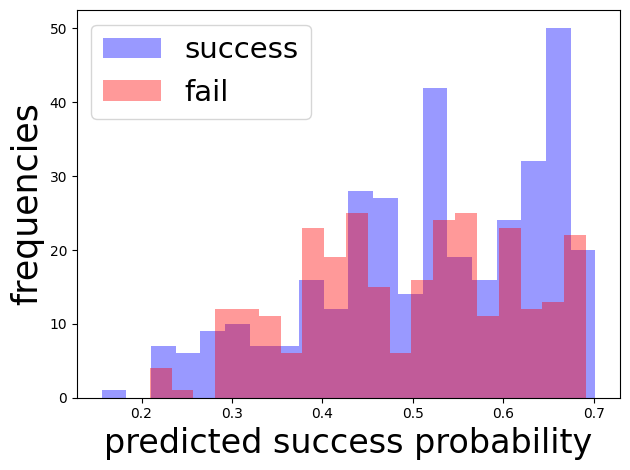

In [6]:
hint_model_path = "save_model/" + base_name + ".ckpt"
if not os.path.exists(hint_model_path):
	model = HINTModel(molecule_encoder = mpnn_model, 
			disease_encoder = gram_model, 
			protocol_encoder = protocol_model,
			device = device, 
			global_embed_size = 50, 
			highway_num_layer = 2,
			prefix_name = base_name, 
			gnn_hidden_size = 50,  
			epoch = 15,
			lr = 5e-4, 
			weight_decay = 1e-3, 
			)
	model.init_pretrain(admet_model)
	train_output, valid_output = model.learn(train_loader, valid_loader, test_loader)
	nctid_all, predict_all = model.bootstrap_test(test_loader, valid_loader=valid_loader)
	torch.save(model, hint_model_path)
else:
	model = torch.load(hint_model_path)
	model.bootstrap_test(test_loader)
	train_loss, train_predict, train_label = model.test(train_loader, return_loss=True)
	test_loss, test_predict, test_label = model.test(test_loader, return_loss=True)

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, f1_score, average_precision_score, precision_score, recall_score, accuracy_score
from scipy.optimize import brentq
from scipy.stats import binom

In [8]:
n = len(test_predict)
test_predict_label = [0] * n
for i in range(n):
    if test_predict[i] > 0.5:
        test_predict_label[i] = 1

accuracy_score(test_predict_label, test_label)

0.5486443381180224

In [9]:
n = len(train_predict)
train_predict_label = [0] * n
for i in range(n):
    if train_predict[i] > 0.5:
        train_predict_label[i] = 1

accuracy_score(train_predict_label, train_label)

0.657088122605364

In [10]:
smx = np.array(train_predict)
labels = np.array(train_label)
a = 1-smx
smx = np.vstack((a, smx))
smx = smx.transpose()
smx.shape

(1044, 2)

In [11]:
n = 200
alpha = 0.1
delta = 0.1
lambdas = np.linspace(0,1,501)
prauc = []
f1 = []
rocauc = []
selective_accuracy = []
improved_accuracy = []
points_kept = []

for i in range(20):
    # Split the softmax scores into calibration and validation sets (save the shuffling)
    idx = np.array([1] * n + [0] * (smx.shape[0]-n)) > 0
    np.random.shuffle(idx)
    cal_smx, val_smx = smx[idx,:], smx[~idx,:]
    cal_labels, val_labels = labels[idx], labels[~idx]
    # Yhat, Phat
    cal_yhats = np.argmax(cal_smx, axis=1); val_yhats = np.argmax(val_smx, axis=1)
    cal_phats = np.max(cal_smx, axis=1); val_phats = np.max(val_smx, axis=1)


    # Define selective risk
    def selective_risk(lam): 
        return (cal_yhats[cal_phats >= lam] != cal_labels[cal_phats >= lam]).sum()/(cal_phats >= lam).sum()
    def nlambda(lam): 
        return (cal_phats > lam).sum()
    def invert_for_ub(r,lam): 
        return binom.cdf(selective_risk(lam)*nlambda(lam),nlambda(lam),r)-delta
    # Construct upper boud
    def selective_risk_ub(lam): 
        return brentq(invert_for_ub,0.1,0.9999,args=(lam,))
    # Make sure there's some data in the top bin.
    lambdas = np.array([lam for lam in lambdas if nlambda(lam) >= 150]) 
    # Scan to choose lamabda hat
    for lhat in np.flip(lambdas):
        # print(lhat)
        print(lhat, selective_risk_ub(lhat-1/lambdas.shape[0]), selective_risk_ub(lhat-1/lambdas.shape[0]) > alpha)
        if selective_risk_ub(lhat-1/lambdas.shape[0]) > alpha: break
    # Deploy procedure on test data
    predictions_kept = val_phats >= lhat

    # Calculate empirical selective accuracy
    test_accuracy = accuracy_score(test_predict_label, test_label)
    empirical_selective_accuracy = (val_yhats[predictions_kept] == val_labels[predictions_kept]).mean()
    empirical_improved_accuracy = empirical_selective_accuracy - test_accuracy
    fraction_kept = predictions_kept.mean()

    val_label_kept = val_labels[predictions_kept]
    val_pred_kept = val_yhats[predictions_kept]
    val_score_kept = val_smx[:,1][predictions_kept]

    prauc_score = average_precision_score(val_label_kept, val_score_kept)
    f1score = f1_score(val_label_kept, val_pred_kept)
    auc_score = roc_auc_score(val_label_kept, val_score_kept)
    precision = precision_score(val_label_kept, val_pred_kept)
    recall = recall_score(val_label_kept, val_pred_kept)
    accuracy = accuracy_score(val_label_kept, val_pred_kept)
    predict_1_ratio = sum(val_pred_kept) / len(val_pred_kept)
    label_1_ratio = sum(val_label_kept) / len(val_label_kept)

    prauc.append(prauc_score)
    f1.append(f1score)
    rocauc.append(auc_score)
    selective_accuracy.append(empirical_selective_accuracy)
    improved_accuracy.append(empirical_improved_accuracy)
    points_kept.append(fraction_kept)

print(f"The original accuracy is:\t\t{test_accuracy:.4F}")
print(f"The empirical selective accuracy is:\tmean: {np.mean(selective_accuracy):.4F}\tstd: {np.std(selective_accuracy):.4f}")
print(f"The empirical improved accuracy is:\tmean: {np.mean(improved_accuracy):.4F}\tstd: {np.std(improved_accuracy):.4f}")
print(f"The fraction of data points kept is:\tmean: {np.mean(points_kept):.4F}\tstd: {np.std(points_kept):.4f}")

print(f"PR_AUC\t mean: {np.mean(prauc):.4F}\tstd: {np.std(prauc):.4f}")
print(f"F1\t mean: {np.mean(f1):.4F}\tstd: {np.std(f1):.4f}")
print(f"ROC_AUC  mean: {np.mean(rocauc):.4F}\tstd: {np.std(rocauc):.4f}")


0.554 0.3508607036019853 True
0.538 0.30368109842562563 True
0.538 0.35567519384109153 True
0.534 0.4216732884759087 True
0.534 0.3278802471240832 True
0.534 0.35770280796317994 True
0.534 0.2966973400692054 True
0.534 0.3313242713914189 True
0.534 0.3857771181375555 True
0.534 0.3636793928357601 True
0.534 0.337767638543699 True
0.534 0.37325515096924666 True
0.534 0.3725668806539195 True
0.534 0.4408299805577162 True
0.534 0.44835356121599995 True
0.534 0.3215599003528717 True
0.534 0.3698935924827509 True
0.534 0.3265181312939036 True
0.534 0.3892693365694524 True
0.534 0.3410062299280009 True
The original accuracy is:		0.5486
The empirical selective accuracy is:	mean: 0.6848	std: 0.0083
The empirical improved accuracy is:	mean: 0.1361	std: 0.0083
The fraction of data points kept is:	mean: 0.8151	std: 0.0190
PR_AUC	 mean: 0.7606	std: 0.0129
F1	 mean: 0.7252	std: 0.0084
ROC_AUC  mean: 0.7149	std: 0.0085


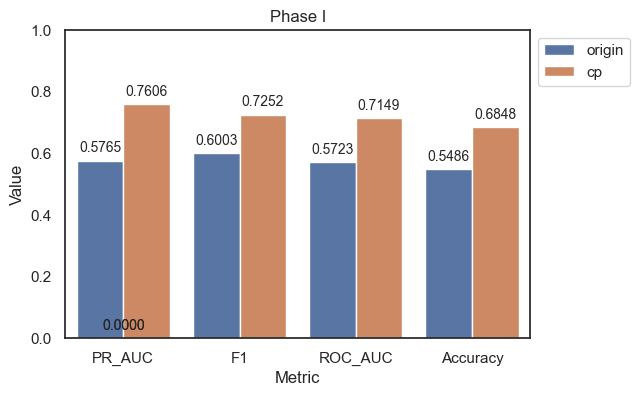

In [21]:
sns.set_theme(style='white')

origin = [0.5765, 0.6003, 0.5723, accuracy_score(test_predict_label, test_label)]
cp = [np.mean(prauc), np.mean(f1), np.mean(rocauc), np.mean(selective_accuracy)]

# X axis
X_labels = ["PR_AUC", "F1", "ROC_AUC", "Accuracy"]

import pandas as pd

data = {
    'Metric': X_labels * 2,  
    'Value': origin + cp,  
    'Type': ['origin']*4 + ['cp']*4  
}

df = pd.DataFrame(data)

plt.figure(figsize=(6, 4))
ax = sns.barplot(x='Metric', y='Value', hue='Type', data=df)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', 
                va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points',
                fontsize = 10)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Phase I')
plt.ylabel('Value')
plt.xlabel('Metric')
plt.ylim(0, 1)

# 显示图形
plt.show()


In [13]:
# Split the softmax scores into calibration and validation sets (save the shuffling)
idx = np.array([1] * n + [0] * (smx.shape[0]-n)) > 0
np.random.shuffle(idx)
cal_smx, val_smx = smx[idx,:], smx[~idx,:]
cal_labels, val_labels = labels[idx], labels[~idx]
# Yhat, Phat
cal_yhats = np.argmax(cal_smx, axis=1); val_yhats = np.argmax(val_smx, axis=1)
cal_phats = np.max(cal_smx, axis=1); val_phats = np.max(val_smx, axis=1)

In [14]:
# Define selective risk
def selective_risk(lam): 
    return (cal_yhats[cal_phats >= lam] != cal_labels[cal_phats >= lam]).sum()/(cal_phats >= lam).sum()
def nlambda(lam): 
    return (cal_phats > lam).sum()
def invert_for_ub(r,lam): 
    return binom.cdf(selective_risk(lam)*nlambda(lam),nlambda(lam),r)-delta
# Construct upper boud
def selective_risk_ub(lam): 
    return brentq(invert_for_ub,0.1,0.9999,args=(lam,))
# Make sure there's some data in the top bin.
lambdas = np.array([lam for lam in lambdas if nlambda(lam) >= 50]) 
# Scan to choose lamabda hat
for lhat in np.flip(lambdas):
    # print(lhat)
    if selective_risk_ub(lhat-1/lambdas.shape[0]) > alpha: break
# Deploy procedure on test data
predictions_kept = val_phats >= lhat
lhat

0.534

In [16]:
train_csv = pd.read_csv(test_file, delimiter=',')
nctids = list(train_csv['nctid'])

_ncts = []
_keeps = []
_yhats = []
_labels = []
_smx = []

for i in range(10):
    rand_nct = np.random.choice(nctids)
    _ncts.append(rand_nct)
    # print(rand_nct, nctids.index(rand_nct))
    idx = nctids.index(rand_nct)
    _smx.append(smx[idx][1])
    _keeps.append(np.max(smx[idx]) >= lhat)
    _yhats.append([np.argmax(smx[idx])])
    _labels.append(labels[idx])

for i in range(len(_ncts)):
    print(f"nctid: {rand_nct} | Probability: {_smx[i]:.4f} | Prediction: {_yhats[i][0]} | Label: {_labels[i]} | Abstained: {~_keeps[i]}")


nctid: NCT02565628 | Probability: 0.5692 | Prediction: 1 | Label: 0 | Abstained: False
nctid: NCT02565628 | Probability: 0.5064 | Prediction: 1 | Label: 0 | Abstained: True
nctid: NCT02565628 | Probability: 0.3791 | Prediction: 0 | Label: 1 | Abstained: False
nctid: NCT02565628 | Probability: 0.6734 | Prediction: 1 | Label: 1 | Abstained: False
nctid: NCT02565628 | Probability: 0.3983 | Prediction: 0 | Label: 0 | Abstained: False
nctid: NCT02565628 | Probability: 0.5559 | Prediction: 1 | Label: 1 | Abstained: False
nctid: NCT02565628 | Probability: 0.4414 | Prediction: 0 | Label: 0 | Abstained: False
nctid: NCT02565628 | Probability: 0.6434 | Prediction: 1 | Label: 0 | Abstained: False
nctid: NCT02565628 | Probability: 0.3745 | Prediction: 0 | Label: 0 | Abstained: False
nctid: NCT02565628 | Probability: 0.3876 | Prediction: 0 | Label: 0 | Abstained: False


In [17]:
def selective_risk2(lam): 
    return (val_yhats[val_phats >= lam] != val_labels[val_phats >= lam]).sum()/(val_phats >= lam).sum()

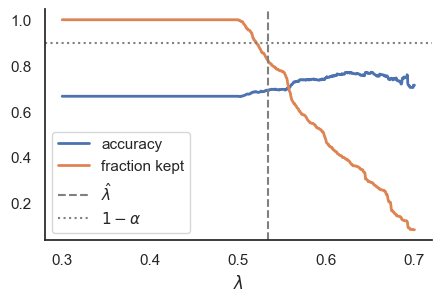

In [23]:
lambdas = np.linspace(0.3,0.7,1001)
sns.set_theme(style='white')
selective_accuracy_curve = [1-selective_risk2(lam) for lam in lambdas]
fraction_kept_curve = [(val_phats >= lam).mean() for lam in lambdas]
fig, axs = plt.subplots(1,1,figsize=(5,3))
axs.plot(lambdas,selective_accuracy_curve,label='accuracy',linewidth=2)
axs.plot(lambdas,fraction_kept_curve,label='fraction kept',linewidth=2)
axs.axvline(x=lhat,linewidth=1.5,linestyle='--',label=r'$\hat{\lambda}$',color='gray')
axs.axhline(y=1-alpha,linewidth=1.5,linestyle='dotted',label=r'$1-\alpha$',color='gray')
sns.despine(ax=axs,top=True,right=True)
axs.legend(loc='lower left')
axs.set_xlabel(r'$\lambda$')
plt.show()

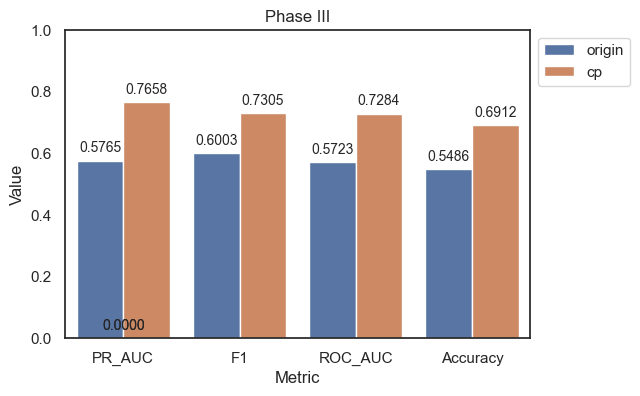

In [19]:
# PR-AUC   mean: 0.5765 std: 0.0174
# F1       mean: 0.6003 std: 0.0218
# ROC-AUC  mean: 0.5723 std: 0.0192

origin = [0.5765, 0.6003, 0.5723, accuracy_score(test_predict_label, test_label)]
cp = [prauc_score, f1score, auc_score, empirical_selective_accuracy]

# X axis
X_labels = ["PR_AUC", "F1", "ROC_AUC", "Accuracy"]

data = {
    'Metric': X_labels * 2,  
    'Value': origin + cp,  
    'Type': ['origin']*4 + ['cp']*4  
}

df = pd.DataFrame(data)

plt.figure(figsize=(6, 4))
ax = sns.barplot(x='Metric', y='Value', hue='Type', data=df)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', 
                va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points',
                fontsize = 10)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Phase III')
plt.ylabel('Value')
plt.xlabel('Metric')
plt.ylim(0, 1)

# 显示图形
plt.show()
